In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

% matplotlib inline

In [0]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [0]:
direct='/content/drive/My Drive/DL_project/nd-twins-0006/faces/'

In [0]:
#read metadata and construct scv for DataLoader
df=pd.read_csv('/content/drive/My Drive/DL_project/image-metadata-3.0.csv')
df_relation=pd.read_csv('/content/drive/My Drive/DL_project/twins-relationship-info.csv')

In [0]:
class TwinsDataloader(Dataset):
    def __init__(self, dataroot, df_img, df_relations, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe matadata(hasn't been changed)
        df_relatinos: pandas dataframe with relations between classes
        transform: torchvision flip and notflip transforms for  images(dict)
        '''
        self.dataroot = dataroot
        self.df = df[df[' yaw']==0]
        self.transform = transform
        self.relations=df_relations
        self.list_notexist=[]
    def __getitem__(self, index):
        
        def get_img_path(img_id):
            return self.dataroot+f'{img_id[:5]}/{img_id[:-4]}__face.jpg'
        
        monetochka=np.random.randint(0,2)
        #print(monetochka)
        id_a = self.df['filename'].iloc[index]
        img_a = Image.open(get_img_path(id_a))
        
        if monetochka==0: 
            find_id=self.relations['subject_id1'].str.find(id_a[:5])
            #print(find_id[find_id!=-1].index.tolist())
            if find_id[find_id!=-1].index.tolist():               
                id_b=self.relations['subject_id2'].iloc[find_id[find_id!=-1].index].values
                relation=self.relations['relationship_type'].iloc[find_id[find_id!=-1].index].values


                if relation[0] in ['Fraternal','Identical','IdenticalMirror','IdenticalTriplet']:
                    flag='Twins'
                    find_id=self.df['filename'].str.find(str(id_b[0][4:]))
                    id_b=self.df['filename'].loc[find_id[find_id!=-1].index[np.random.randint(0,len(find_id[find_id!=-1].index))]]
                    img_b = Image.open(get_img_path(id_b))
                    img_b=self.transform['notflip'](img_b)
                else:
                    id_b=id_a
                    img_b=img_a.copy()
                    img_b=self.transform['flip'](img_b)
                    flag='Not Twins'
            else:
                id_b=id_a
                img_b=img_a.copy()
                img_b=self.transform['flip'](img_b)
                flag='Not Twins'
        else:
            id_b=id_a
            img_b=img_a.copy()
            img_b=self.transform['flip'](img_b)
            flag='Not Twins'
    
        img_a = self.transform['notflip'](img_a)

        id_a=id_a[:5]
        id_b=id_b[:5]
        return {'img_a': img_a, 'img_b': img_b, 'class_a':id_a,'class_b':id_b,'label':flag}

    def __len__(self):
        return self.df.shape[0]

In [0]:
data_transforms = {
    'flip': transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(p=1),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'notflip': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

## Check work of dataloader

In [0]:
twins_dataset = TwinsDataloader(direct, df,df_relation ,data_transforms)
dataset = DataLoader(twins_dataset, batch_size=5,shuffle=True)

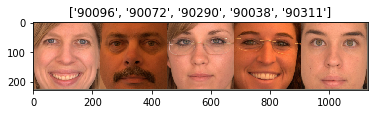

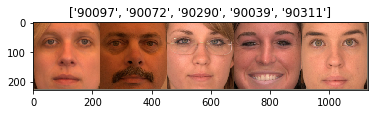

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
T = next(iter(dataset))

# Make a grid from batch
out = torchvision.utils.make_grid(T['img_a'])
imshow(out, title=[x for x in T['class_a']])

out = torchvision.utils.make_grid(T['img_b'])
imshow(out, title=[x for x in T['class_b']])

## Load and define the model

In [0]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
import torch.nn.functional as F
import torch
from collections import namedtuple
import math
import pdb

##################################  Original Arcface Model #############################################################

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class SEModule(Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0 ,bias=False)
        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0 ,bias=False)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class bottleneck_IR(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False), BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1 ,bias=False), PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1 ,bias=False), BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class bottleneck_IR_SE(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR_SE, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False), 
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3,3), (1,1),1 ,bias=False),
            PReLU(depth),
            Conv2d(depth, depth, (3,3), stride, 1 ,bias=False),
            BatchNorm2d(depth),
            SEModule(depth,16)
            )
    def forward(self,x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''
    
def get_block(in_channel, depth, num_units, stride = 2):
  return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units-1)]

def get_blocks(num_layers):
    if num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units = 3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=8),
            get_block(in_channel=128, depth=256, num_units=36),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    return blocks

class Backbone(Module):
    def __init__(self, num_layers, drop_ratio, mode='ir'):
        super(Backbone, self).__init__()
        assert num_layers in [50, 100, 152], 'num_layers should be 50,100, or 152'
        assert mode in ['ir', 'ir_se'], 'mode should be ir or ir_se'
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1 ,bias=False), 
                                      BatchNorm2d(64), 
                                      PReLU(64))
        self.output_layer = Sequential(BatchNorm2d(512), 
                                       Dropout(drop_ratio),
                                       Flatten(),
                                       Linear(512 * 7 * 7, 512),
                                       BatchNorm1d(512))
        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel,
                                bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)
    
    def forward(self,x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)
        return l2_norm(x)

##################################  MobileFaceNet #############################################################
    
class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)

class MobileFaceNet(Module):
    def __init__(self, embedding_size):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)
        
        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.conv_6_dw(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)

##################################  Arcface head #############################################################

class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

##################################  Cosface head #############################################################    
    
class Am_softmax(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self,embedding_size=512,classnum=51332):
        super(Am_softmax, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = 0.35 # additive margin recommended by the paper
        self.s = 30. # see normface https://arxiv.org/abs/1704.06369
    def forward(self,embbedings,label):
        kernel_norm = l2_norm(self.kernel,axis=0)
        cos_theta = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        phi = cos_theta - self.m
        label = label.view(-1,1) #size=(B,1)
        index = cos_theta.data * 0.0 #size=(B,Classnum)
        index.scatter_(1,label.data.view(-1,1),1)
        index = index.byte()
        output = cos_theta * 1.0
        output[index] = phi[index] #only change the correct predicted output
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output



In [19]:
#from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"/content/drive/My Drive/DL_project/model_mobilefacenet.pth")

checkpoint = torch.load(PATH)

model.load_state_dict(checkpoint)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [1]:
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

#define model and fix hidden features size
model_flatten = ModelBottom(model)

outputs = model_flatten(T['img_a'])
hid_size=outputs.data.shape[1]

label_dict={'Twins':1,'Not Twins':0}

NameError: name 'nn' is not defined

In [0]:
model_flatten_classifier = nn.Sequential(
                      nn.Linear(hid_size, 500),
                      nn.Dropout(0.5),
                      nn.ReLU(), 
                      nn.Linear(500, hid_size),
                      nn.Dropout(0.5),
                      nn.ReLU())

In [0]:
def train(support_model,model,dataloader,optimizer,criterion,device,n_epochs=100):
  model.cuda()
  support_model.cuda()
  loss_hist=[]

  for epoch in range(n_epochs):
    #loss_epoch=0
    for i,batch_item in enumerate(dataloader):

      result_img_a=support_model(batch_item['img_a'].cuda())
      result_img_b=support_model(batch_item['img_b'].cuda())
      label=batch_item['label']
      label=[label_dict[x] for x in label]
      loss_batch=0
      for i in range(result_img_a.shape[0]):
        img_a=model(result_img_a[i])
        img_b=model(result_img_b[i])
        optimizer.zero_grad()
        loss=criterion(result_img_a,result_img_b,label[i])
        loss.backward(retain_graph=True)
        loss_batch+=loss.item()
        optimizer.step()
      loss_epoch+=loss_batch
      #print(loss_batch)
      
      loss_hist.append(loss_batch)
      plt.plot(loss_hist) 
      plt.title('loss')
      plt.legend()
      plt.show()
    

## Model for classification